In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import GPy
from IPython.display import display
import os
os.chdir("../..")
import descriptor.three_desc_model as tdm
from descriptor.cutoffs import Polynomial
GPy.plotting.change_plotting_library('matplotlib')

In [2]:
#dataset = pd.read_csv('dataset_10m_s.csv', index_col=0)
dataset = pd.read_csv('turb_data.csv')
dataset=dataset[dataset['wind_speed']==10].reset_index(drop=True)
dataset=dataset.drop(['ID'], axis=1)

dataset["IDnum"] = dataset["IDnum"] - dataset["IDnum"].iloc[0]
numsims=(dataset["IDnum"].iloc[-1]-dataset["IDnum"].iloc[0])+1
symbol = "Siemens"
turb = [symbol]

In [11]:
dataset
#numsims

x_coord     y_coord  ref_wind_speed  wind_speed  turb_num  \
0        0.000000    0.000000        7.400279          10         0   
1      649.414197   45.411464        6.188747          10         1   
2        0.000000    0.000000        7.451596          10         0   
3      360.950010   89.994945        7.065012          10         1   
4        0.000000    0.000000        7.479762          10         0   
...           ...         ...             ...         ...       ...   
1899   200.175764  489.000000        7.338118          10         1   
1900  1356.816032  222.000000        7.412421          10         2   
1901     0.000000    0.000000        7.312825          10         0   
1902  1619.424352   19.000000        6.380592          10         1   
1903   467.386268 -262.000000        7.372731          10         2   

      num_tot_turb  IDnum  
0                2      0  
1                2      0  
2                2      1  
3                2      1  
4                2      2  
...            ...    ...  
1899             3   2575  
1900             3   2575  
1901             3   2576  
1902             3   2576  
1903             3   2576  

[1904 rows x 7 columns]

In [9]:
dataset["num_tot_turb"].iloc[1903]

3

In [6]:
nl=tdm.NeighborlistCalculator(cutoff=4001,cone_grad=0.12582561117875557, cone_offset=72.24947126849844)
Gs = {"Siemens": [{"type":"G2", "turbine":"Siemens","eta":4.25387599, "offset": 1.0151402},
                  {"type":"G4", "elements":"Siemens","eta":2.56450515, "gamma":8.04475192},
                  {"type":"G6", "elements":"Siemens","eta":2.33043463, "gamma": 0.50753377}
                 ]}
finpr=tdm.FingerprintCalculator(cutoff=4001,Gs=Gs,Rct=3000,delta_R=100,cone_grad=0.12582561117875557, cone_offset=72.24947126849844)
count=0
dataset_fp=np.empty(shape=(0, 3))
dataset_ws=np.empty(shape=(0, 1))
dataset_pos=np.empty(shape=(0, 2))
for i in range(numsims):
    #print(i)
    numturb=dataset["num_tot_turb"].iloc[count]
    position = np.empty((numturb,2))
    ws = np.empty((numturb,1))
    fp = np.empty((numturb,3))
    for k in range(numturb):
        position[k,0]=dataset.at[count,"x_coord"]
        position[k,1]=dataset.at[count,"y_coord"]
        ws[k,0]=dataset.at[count,"ref_wind_speed"]
        count = count+ 1
    neigh=nl.calculate(turb*numturb,position)
    fingerprints=finpr.calculate(turb*numturb,position,neigh,symbol)
    fingerprints=np.array(fingerprints)
    dataset_fp=np.append(dataset_fp,fingerprints,axis=0)
    dataset_ws=np.append(dataset_ws,ws,axis=0)
    dataset_pos=np.append(dataset_pos,position,axis=0)
dataset=np.concatenate((dataset_fp, dataset_ws),axis=1)
dataset = pd.DataFrame(dataset, columns = ['Fingerprint(G2)','Fingerprint(G4)','Fingerprint(G6)','Ref_Wind_Speed'])
X=dataset[["Fingerprint(G2)","Fingerprint(G4)","Fingerprint(G6)"]].to_numpy()
Y=dataset[["Ref_Wind_Speed"]].to_numpy()
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)
Xtrain=train_dataset[["Fingerprint(G2)","Fingerprint(G4)","Fingerprint(G6)"]].to_numpy()
Ytrain=train_dataset[["Ref_Wind_Speed"]].to_numpy()
Xtest=test_dataset[["Fingerprint(G2)","Fingerprint(G4)","Fingerprint(G6)"]].to_numpy()
Ytest=test_dataset[["Ref_Wind_Speed"]].to_numpy()

IndexError: single positional indexer is out-of-bounds

In [ ]:
plt.scatter(Xtrain[:,0],Xtrain[:,1])

NameError: name 'Xtrain' is not defined

In [ ]:
# define kernel
ker = GPy.kern.RBF(3,lengthscale=0.1)# + GPy.kern.White(2)

In [ ]:
# create simple GP model
m = GPy.models.GPRegression(Xtrain,Ytrain,ker)

NameError: name 'Xtrain' is not defined

In [ ]:
# optimize and plot
m.optimize(messages=True,max_f_eval = 1000)
#fig = m.plot()
#display(GPy.plotting.show(fig, filename='basic_gp_regression_notebook_2d'))
display(m)

NameError: name 'm' is not defined

In [ ]:
print(m)

NameError: name 'm' is not defined

In [ ]:
[Ypred,Yvar]=m.predict(Xtest)
error_test=np.abs(Ypred-Ytest)
np.max(error_test)

NameError: name 'm' is not defined

In [ ]:
[Yval,Yvalvar]=m.predict(Xtrain)
error_train=np.abs(Yval-Ytrain)
np.max(error_train)

0.2535218042888081

In [ ]:
[Yall,Yallvar]=m.predict(X)
error_all=np.abs(Yall-Y)
np.max(error_all)

0.3023212578959651

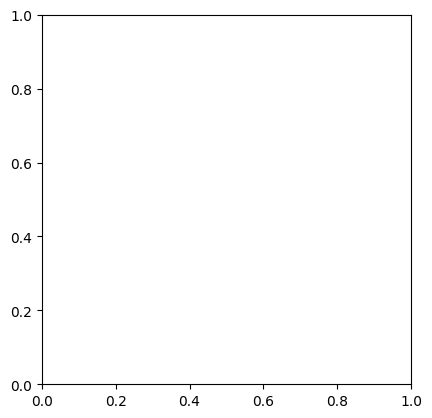

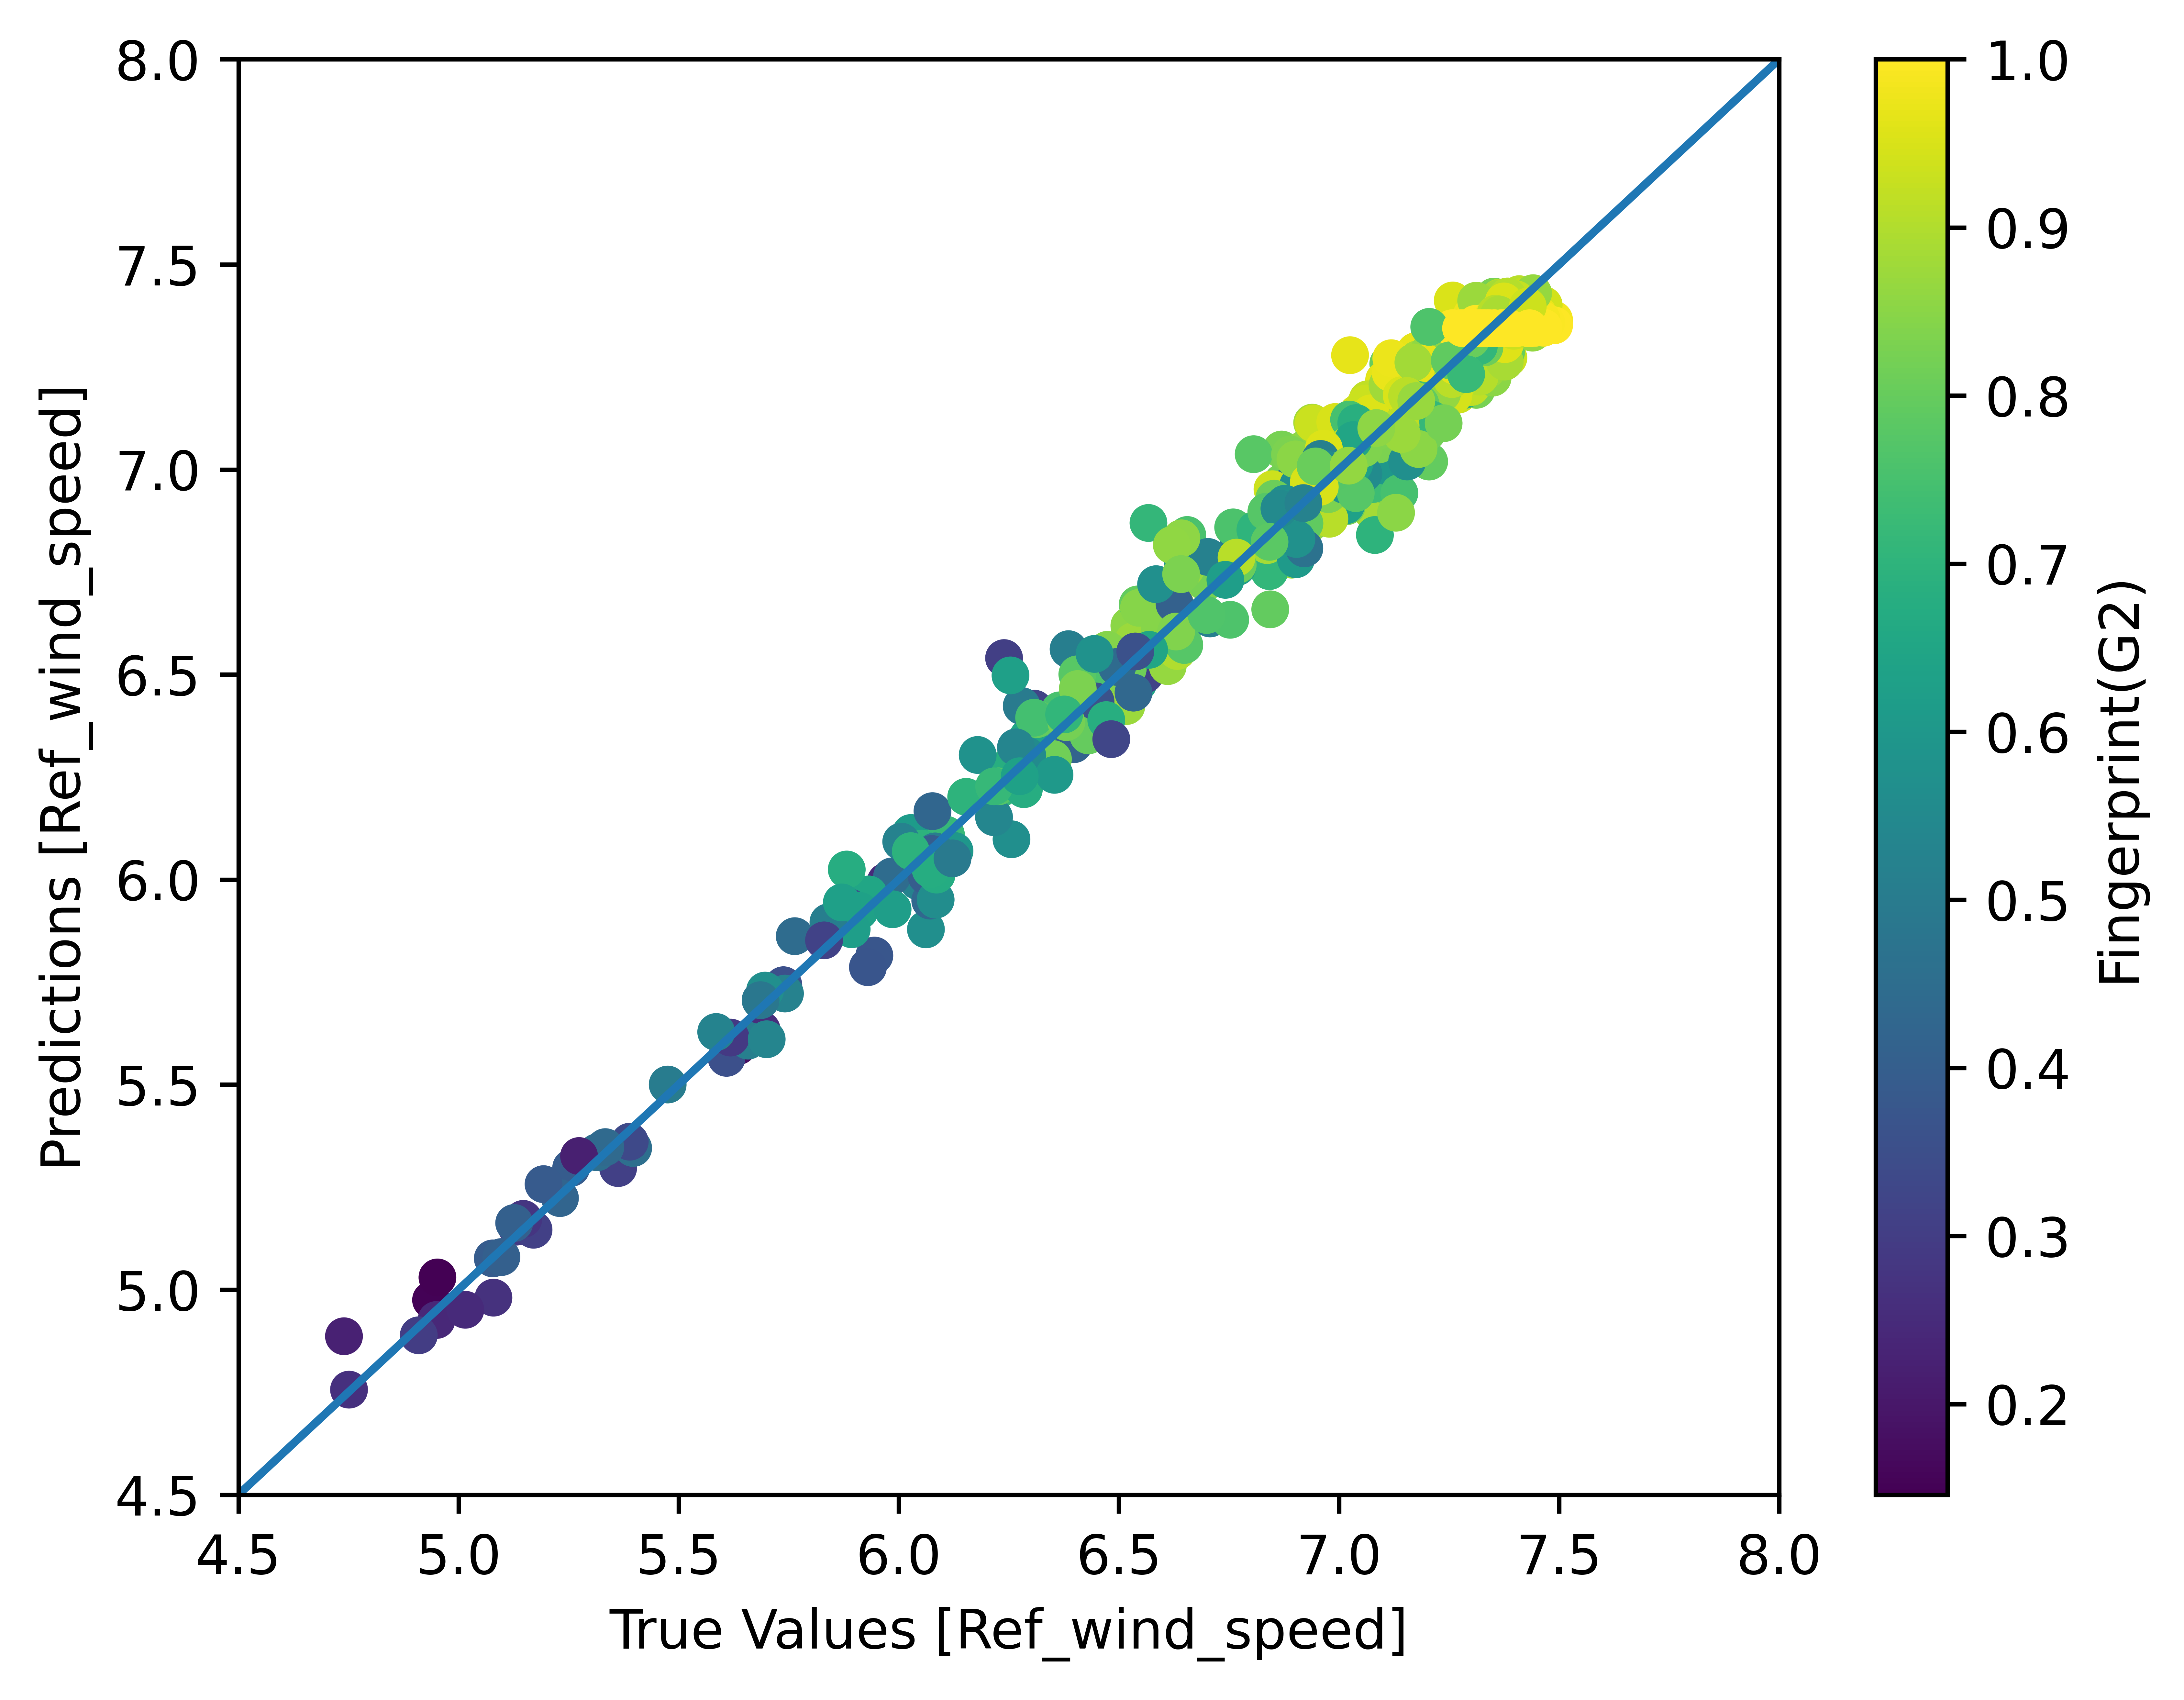

In [ ]:
a = plt.axes(aspect='equal')
plt.figure(dpi=1200)
plt.scatter(Ytest, Ypred,c=Xtest[:,0])     #"Fingerprint(G2)"
plt.scatter(Ytrain, Yval,c=Xtrain[:,0])  #"Fingerprint(G2)"
plt.xlabel('True Values [Ref_wind_speed]')
plt.ylabel('Predictions [Ref_wind_speed]')
cbar=plt.colorbar()
cbar.set_label('Fingerprint(G2)')
lims = [4.5, 8]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

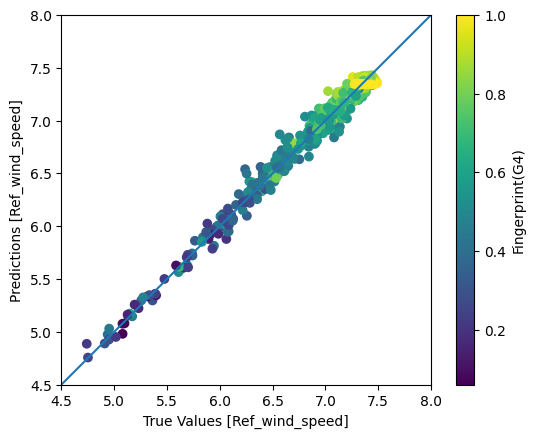

In [ ]:
a = plt.axes(aspect='equal')
plt.scatter(Ytest, Ypred,c=Xtest[:,1])     #"Fingerprint(G4)"
plt.scatter(Ytrain, Yval,c=Xtrain[:,1])  #"Fingerprint(G4)"
plt.xlabel('True Values [Ref_wind_speed]')
plt.ylabel('Predictions [Ref_wind_speed]')
cbar=plt.colorbar()
cbar.set_label('Fingerprint(G4)')
lims = [4.5, 8]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

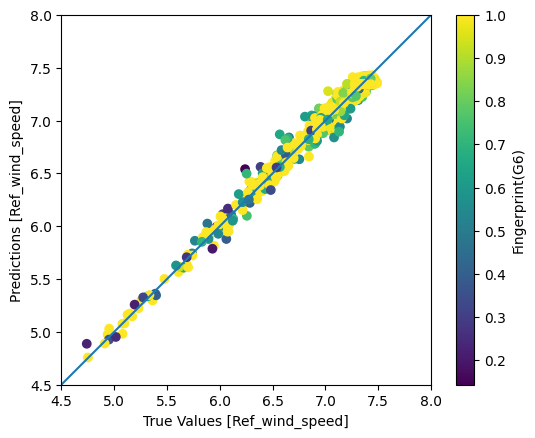

In [ ]:
a = plt.axes(aspect='equal')
plt.scatter(Ytest, Ypred,c=Xtest[:,2])     #"Fingerprint(G6)"
plt.scatter(Ytrain, Yval,c=Xtrain[:,2])  #"Fingerprint(G6)"
plt.xlabel('True Values [Ref_wind_speed]')
plt.ylabel('Predictions [Ref_wind_speed]')
cbar=plt.colorbar()
cbar.set_label('Fingerprint(G6)')
lims = [4.5, 8]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

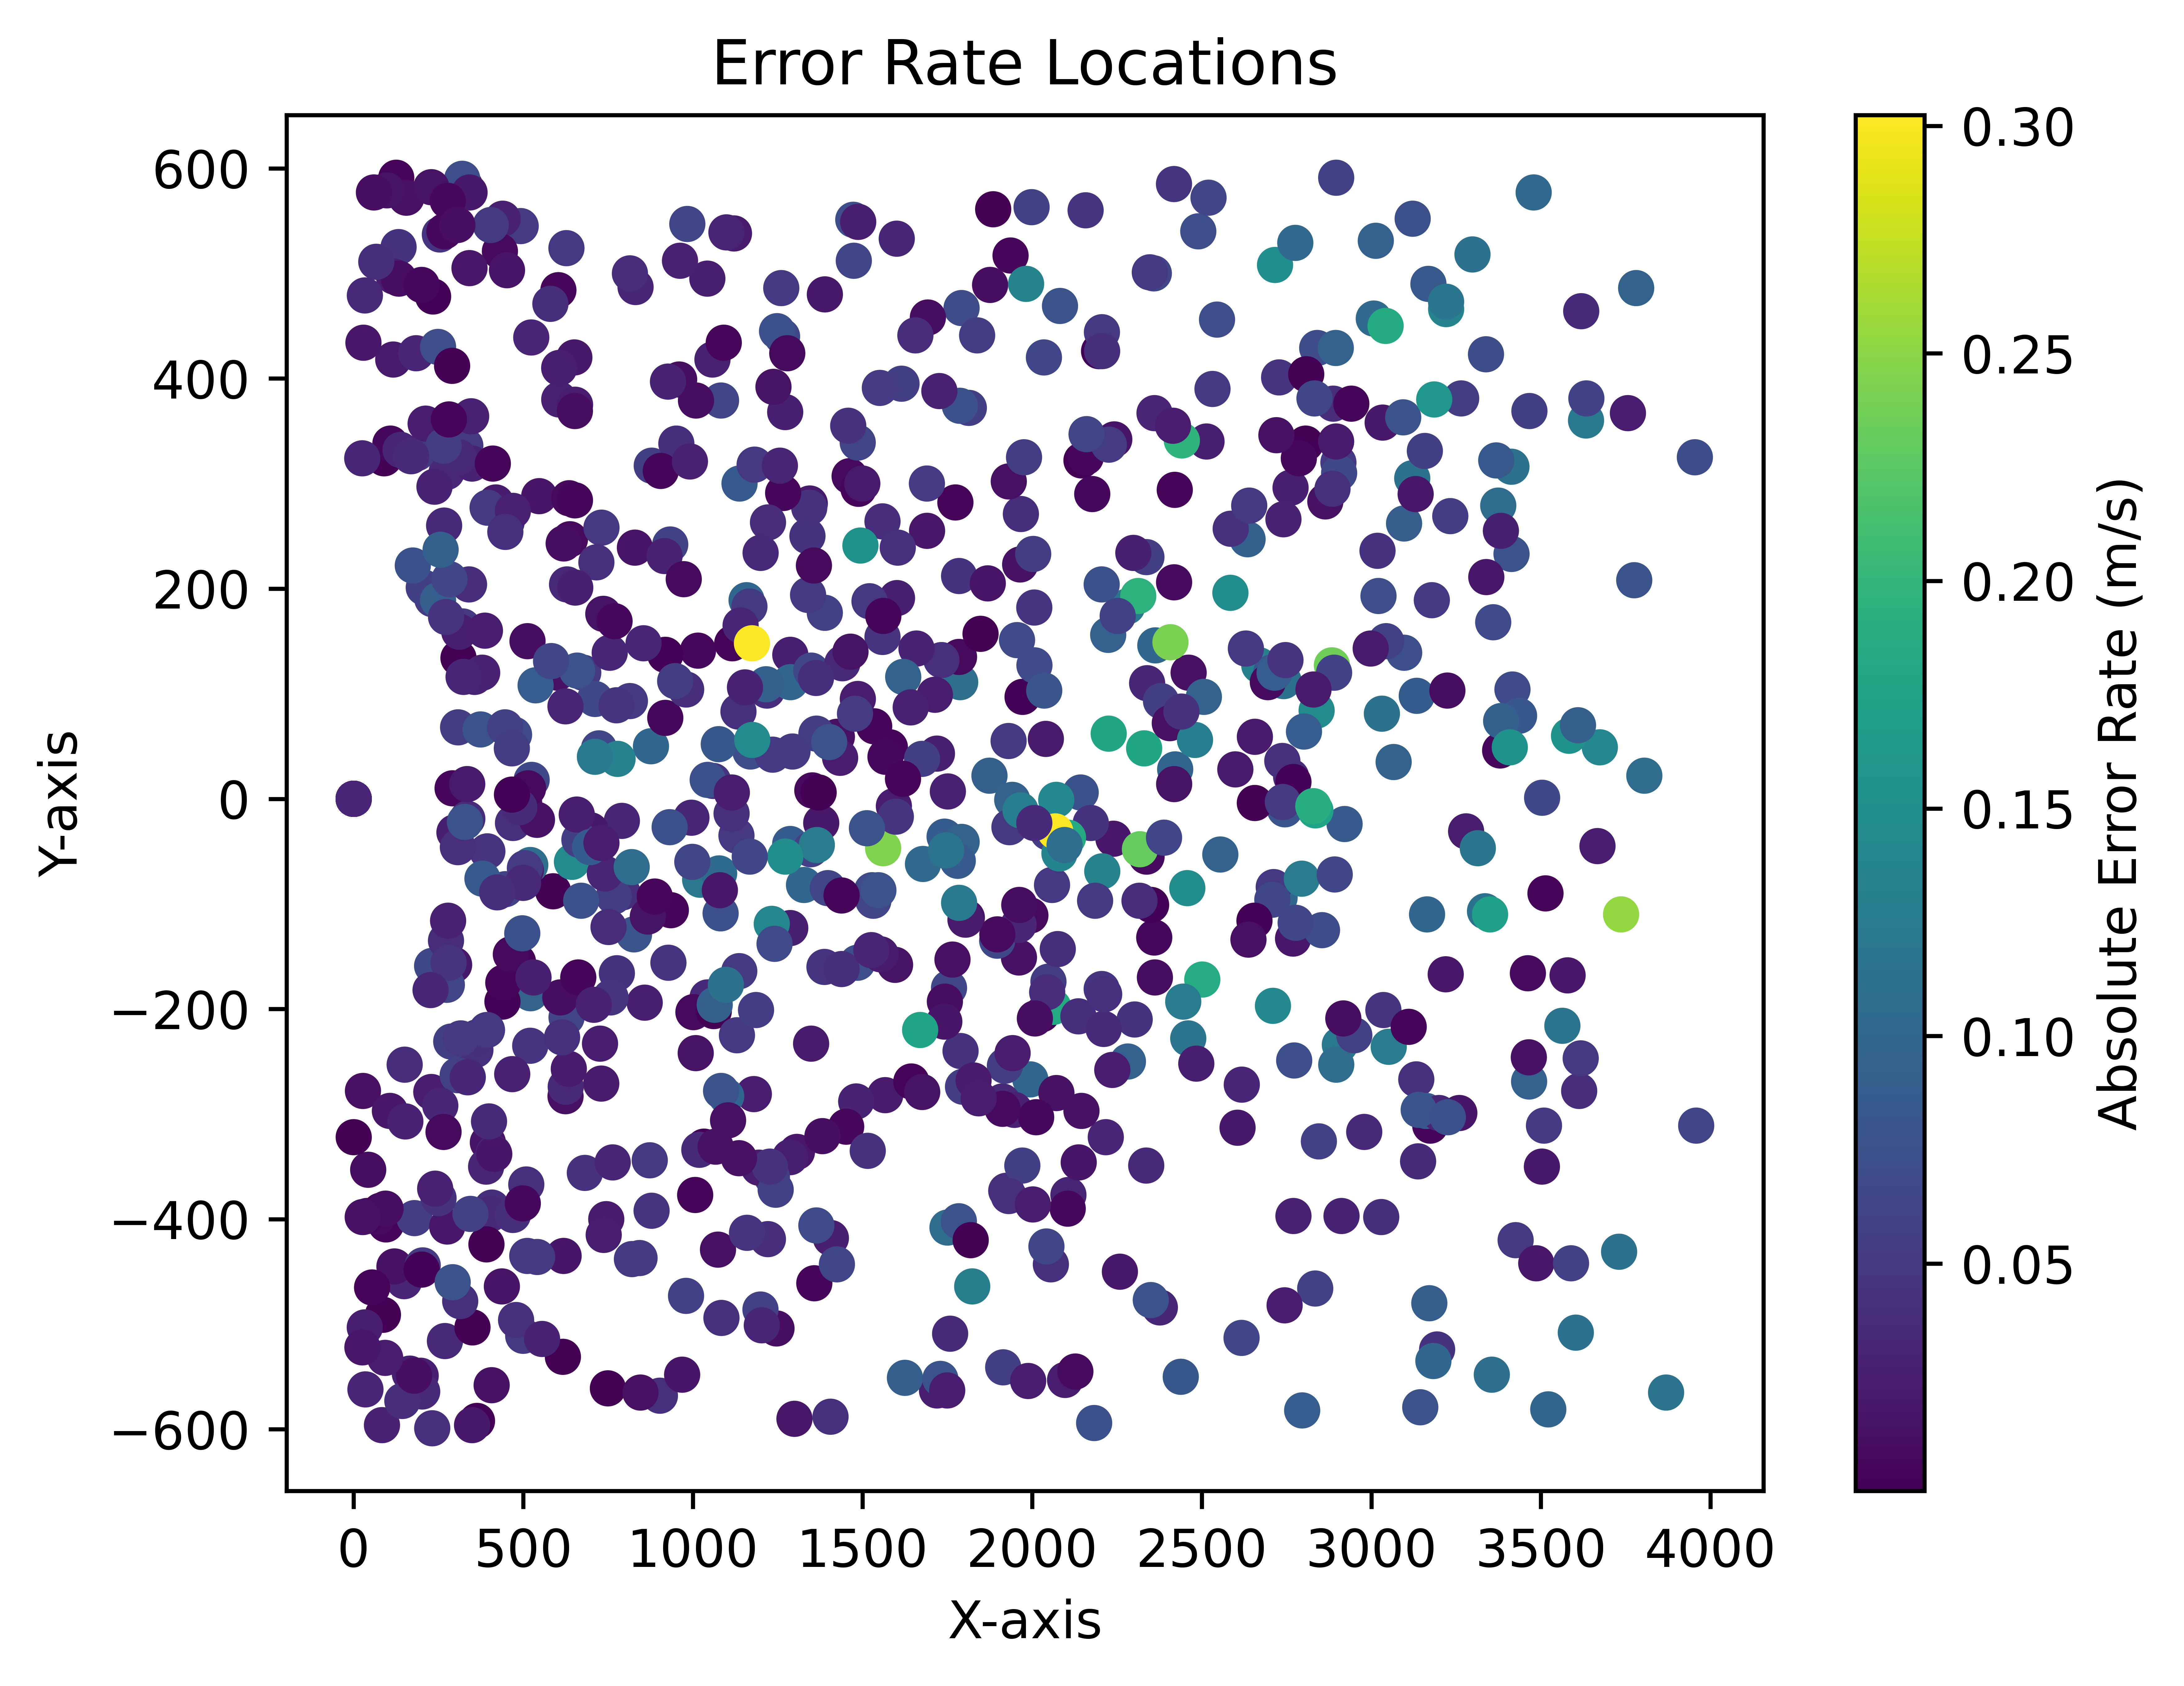

In [ ]:
plt.figure(dpi=1200)
plt.scatter(dataset_pos[:,0], dataset_pos[:,1],c=error_all)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Error Rate Locations')
cbar=plt.colorbar()
cbar.set_label('Absolute Error Rate (m/s)')

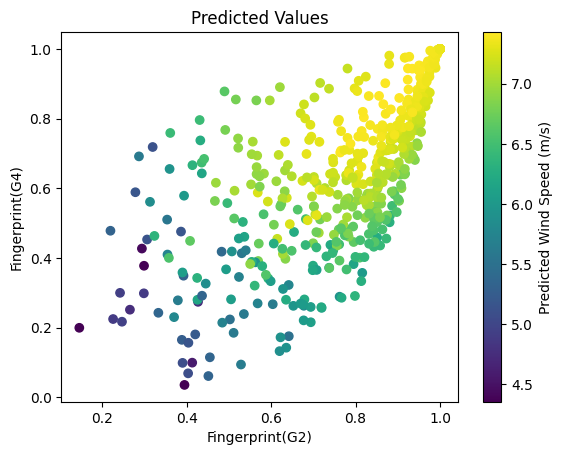

In [ ]:
a = plt.axes
plt.scatter(Xtest[:,0], Xtest[:,1],c=np.abs(Ypred))
plt.scatter(Xtrain[:,0], Xtrain[:,1],c=np.abs(Yval))
#plt.scatter(train_labels, train_predictions)
plt.xlabel('Fingerprint(G2)')
plt.ylabel('Fingerprint(G4)')
plt.title('Predicted Values')
cbar=plt.colorbar()
cbar.set_label('Predicted Wind Speed (m/s)')

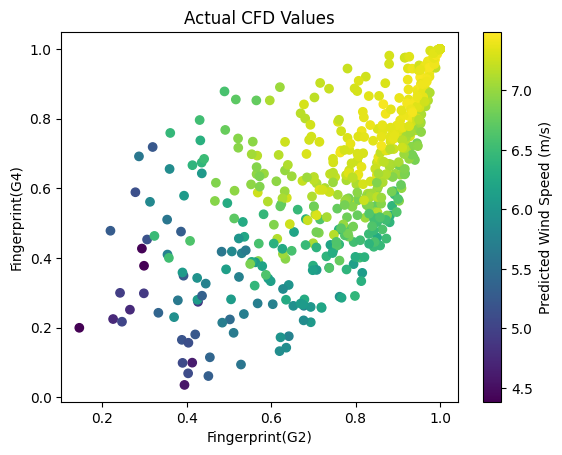

In [ ]:
a = plt.axes
plt.scatter(Xtest[:,0], Xtest[:,1],c=np.abs(Ytest))
plt.scatter(Xtrain[:,0], Xtrain[:,1],c=np.abs(Ytrain))
#plt.scatter(train_labels, train_predictions)
plt.xlabel('Fingerprint(G2)')
plt.ylabel('Fingerprint(G4)')
plt.title('Actual CFD Values')
cbar=plt.colorbar()
cbar.set_label('Predicted Wind Speed (m/s)')

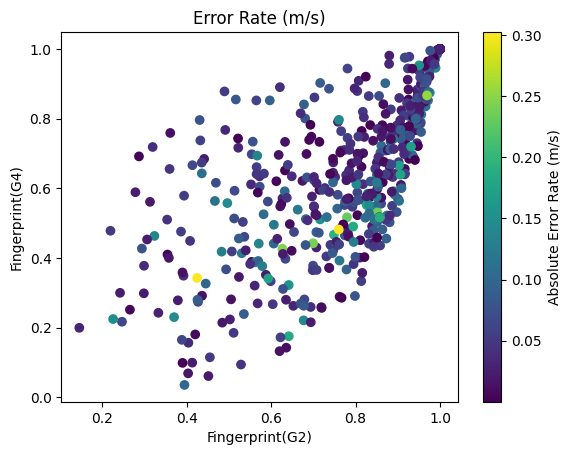

In [ ]:
a = plt.axes
plt.scatter(X[:,0], X[:,1],c=error_all)
#plt.scatter(Xtrain[:,0], Xtrain[:,1],c=np.abs(Ytrain))
#plt.scatter(train_labels, train_predictions)
plt.xlabel('Fingerprint(G2)')
plt.ylabel('Fingerprint(G4)')
plt.title('Error Rate (m/s)')
cbar=plt.colorbar()
cbar.set_label('Absolute Error Rate (m/s)')

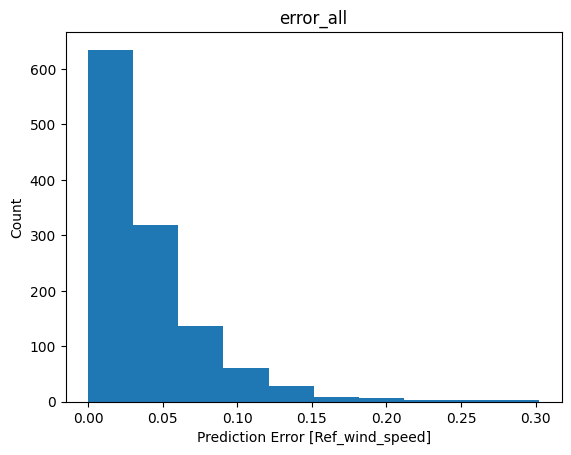

In [ ]:
plt.hist(error_all, bins=10)
plt.xlabel('Prediction Error [Ref_wind_speed]')
plt.title('error_all')
_ = plt.ylabel('Count')

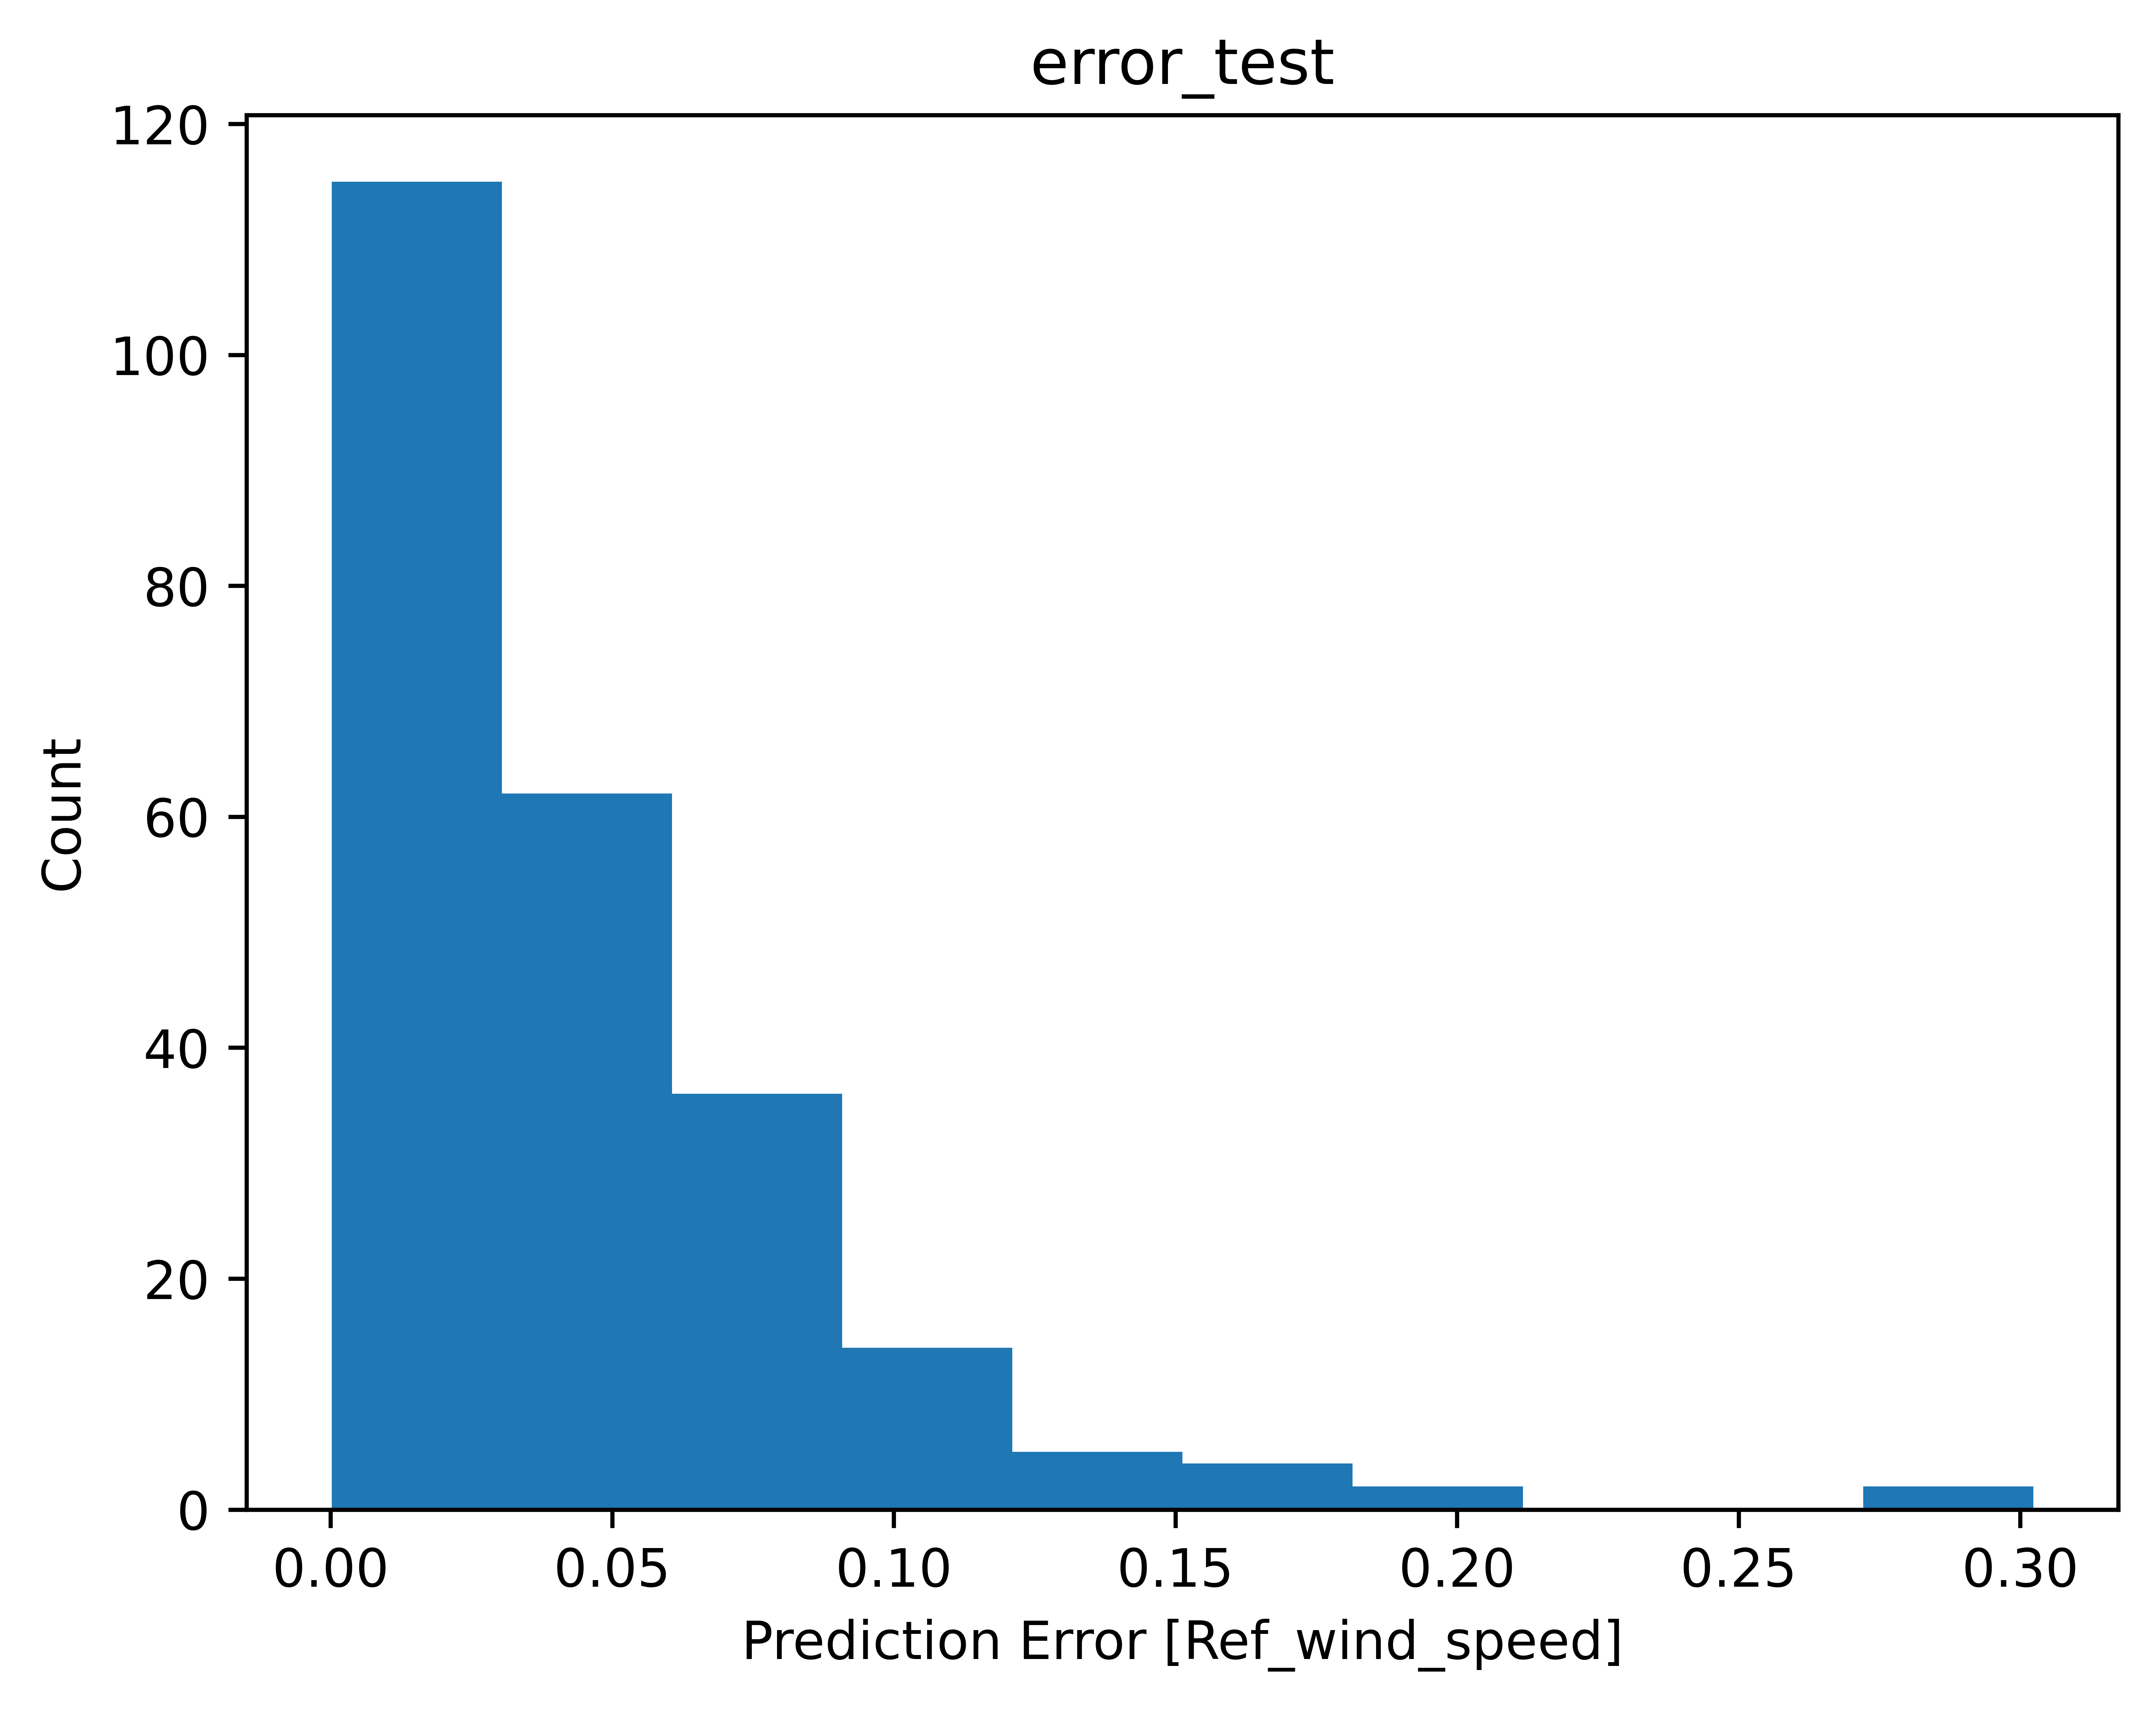

In [ ]:
plt.figure(dpi=1200)
plt.hist(error_test, bins=10)
plt.xlabel('Prediction Error [Ref_wind_speed]')
plt.title('error_test')
_ = plt.ylabel('Count')